In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [45]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [46]:
df = pd.read_csv('color_game_simulation_clean.csv')

In [47]:
df.head

<bound method NDFrame.head of        play_number model_type  bet selected_color  matches  profit
0                1       fair  100           Pink        1     100
1                2       fair  100           Pink        0    -100
2                3       fair  100           Pink        1     100
3                4       fair  100           Pink        1     100
4                5       fair  100           Pink        0    -100
...            ...        ...  ...            ...      ...     ...
39995        19996    tweaked  100          Green        1     100
39996        19997    tweaked  100         Yellow        0    -100
39997        19998    tweaked  100          White        1     100
39998        19999    tweaked  100         Yellow        1     100
39999        20000    tweaked  100          Green        0    -100

[40000 rows x 6 columns]>

In [48]:
df.shape

(40000, 6)

In [49]:
df.dtypes

play_number        int64
model_type        object
bet                int64
selected_color    object
matches            int64
profit             int64
dtype: object

In [50]:
df.isnull().sum()

play_number       0
model_type        0
bet               0
selected_color    0
matches           0
profit            0
dtype: int64

In [51]:
summary_stats = df.groupby('model_type').agg({
    'bet': ['sum', 'mean'],
    'profit': ['sum', 'mean', 'std'],
    'matches': ['mean', 'std'],
    'play_number': 'count'
}).round(2)

In [52]:
summary_stats.columns = ['Total_Bet', 'Avg_Bet', 'Total_Profit', 'Avg_Profit', 
                         'Std_Profit', 'Avg_Matches', 'Std_Matches', 'Total_Plays']
print(summary_stats)

            Total_Bet  Avg_Bet  Total_Profit  Avg_Profit  Std_Profit  \
model_type                                                             
fair          2000000    100.0       -131600       -6.58      111.45   
tweaked       2000000    100.0       -171500       -8.57      111.30   

            Avg_Matches  Std_Matches  Total_Plays  
model_type                                         
fair               0.51         0.65        20000  
tweaked            0.50         0.65        20000  


In [53]:
for model in df['model_type'].unique():
    model_data = df[df['model_type'] == model]
    total_bet = model_data['bet'].sum()
    total_profit = model_data['profit'].sum()
    house_profit = -total_profit
    house_edge = (house_profit / total_bet) * 100
    win_rate = (len(model_data[model_data['profit'] > 0]) / len(model_data)) * 100
    
    print(f"\n{model.upper()} Game:")
    print(f"  Win Rate: {win_rate:.2f}%")
    print(f"  House Profit: ₱{house_profit:.2f}")
    print(f"  House Edge: {house_edge:.2f}%")


FAIR Game:
  Win Rate: 42.75%
  House Profit: ₱131600.00
  House Edge: 6.58%

TWEAKED Game:
  Win Rate: 41.76%
  House Profit: ₱171500.00
  House Edge: 8.58%


---
### **3. CUMULATIVE PROFIT OVER TIME**
---

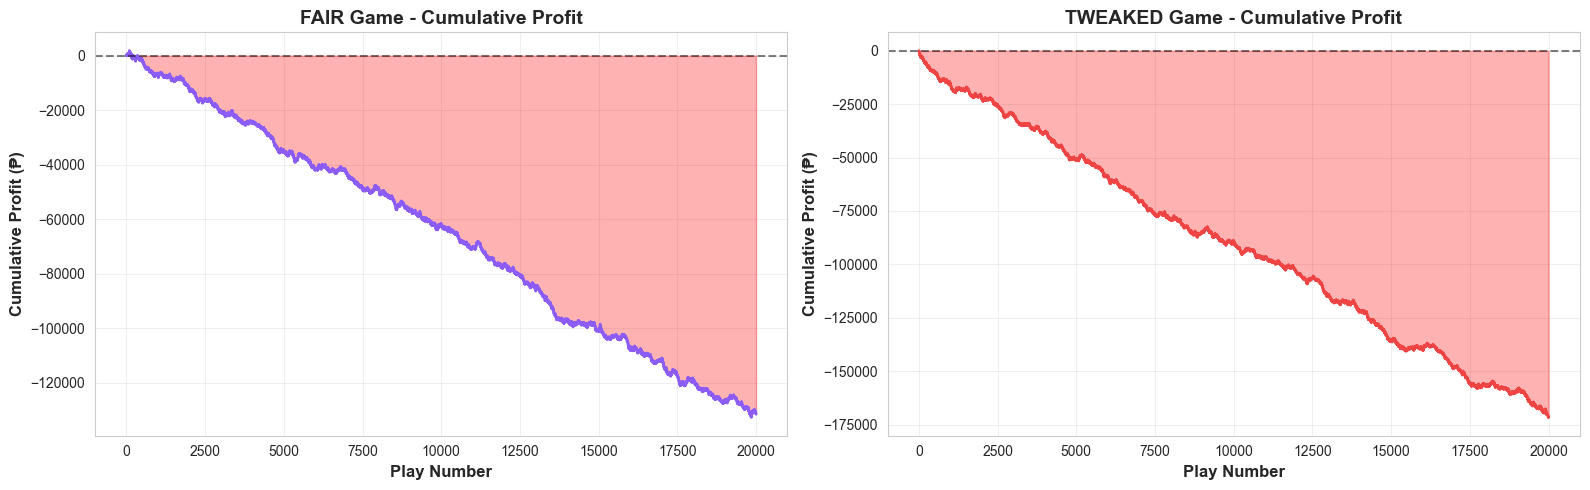

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for idx, model in enumerate(df['model_type'].unique()):
    model_data = df[df['model_type'] == model].copy()
    model_data['cumulative_profit'] = model_data['profit'].cumsum()
    
    axes[idx].plot(model_data['play_number'], model_data['cumulative_profit'], 
                   linewidth=2, color='#8b5cf6' if model == 'fair' else '#ef4444')
    axes[idx].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[idx].fill_between(model_data['play_number'], 
                           model_data['cumulative_profit'], 
                           0, alpha=0.3,
                           color='green' if model_data['cumulative_profit'].iloc[-1] > 0 else 'red')
    axes[idx].set_xlabel('Play Number', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Cumulative Profit (₱)', fontsize=12, fontweight='bold')
    axes[idx].set_title(f'{model.upper()} Game - Cumulative Profit', 
                       fontsize=14, fontweight='bold')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('cumulative_profit_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

---
### **MATCH DISTRIBUTION COMPARISON**
---

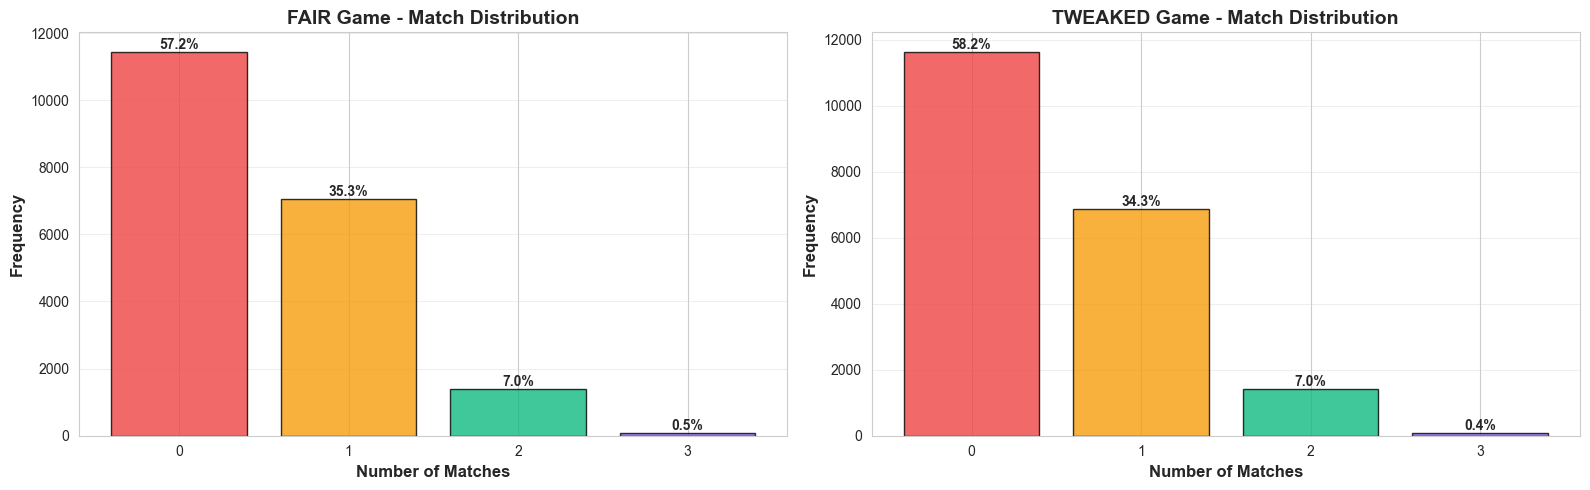

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for idx, model in enumerate(df['model_type'].unique()):
    model_data = df[df['model_type'] == model]
    match_counts = model_data['matches'].value_counts().sort_index()
    match_pct = (match_counts / len(model_data) * 100).round(2)
    
    colors = ['#ef4444', '#f59e0b', '#10b981', '#8b5cf6']
    bars = axes[idx].bar(match_counts.index, match_counts.values, 
                         color=colors[:len(match_counts)], alpha=0.8, edgecolor='black')
    
    # Add percentage labels on bars
    for bar, pct in zip(bars, match_pct.values):
        height = bar.get_height()
        axes[idx].text(bar.get_x() + bar.get_width()/2., height,
                      f'{pct:.1f}%',
                      ha='center', va='bottom', fontweight='bold')
    
    axes[idx].set_xlabel('Number of Matches', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Frequency', fontsize=12, fontweight='bold')
    axes[idx].set_title(f'{model.upper()} Game - Match Distribution', 
                       fontsize=14, fontweight='bold')
    axes[idx].set_xticks([0, 1, 2, 3])
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('match_distribution_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [56]:
# Theoretical vs Actual Probabilities
print("\n" + "="*80)
print("THEORETICAL vs ACTUAL MATCH PROBABILITIES")
print("="*80)

theoretical_probs = {
    0: 57.87,
    1: 34.72,
    2: 6.94,
    3: 0.46
}

for model in df['model_type'].unique():
    print(f"\n{model.upper()} Game:")
    model_data = df[df['model_type'] == model]
    match_pct = (model_data['matches'].value_counts().sort_index() / len(model_data) * 100)
    
    print(f"{'Matches':<10} {'Theoretical':<15} {'Actual':<15} {'Difference':<15}")
    print("-" * 55)
    for matches in [0, 1, 2, 3]:
        actual = match_pct.get(matches, 0)
        theo = theoretical_probs[matches]
        diff = actual - theo
        print(f"{matches:<10} {theo:>10.2f}%     {actual:>10.2f}%     {diff:>10.2f}%")


THEORETICAL vs ACTUAL MATCH PROBABILITIES

FAIR Game:
Matches    Theoretical     Actual          Difference     
-------------------------------------------------------
0               57.87%          57.25%          -0.62%
1               34.72%          35.30%           0.58%
2                6.94%           7.01%           0.07%
3                0.46%           0.45%          -0.01%

TWEAKED Game:
Matches    Theoretical     Actual          Difference     
-------------------------------------------------------
0               57.87%          58.24%           0.37%
1               34.72%          34.30%          -0.42%
2                6.94%           7.02%           0.08%
3                0.46%           0.45%          -0.02%


---
### **PROFIT DISTRIBUTION**
---

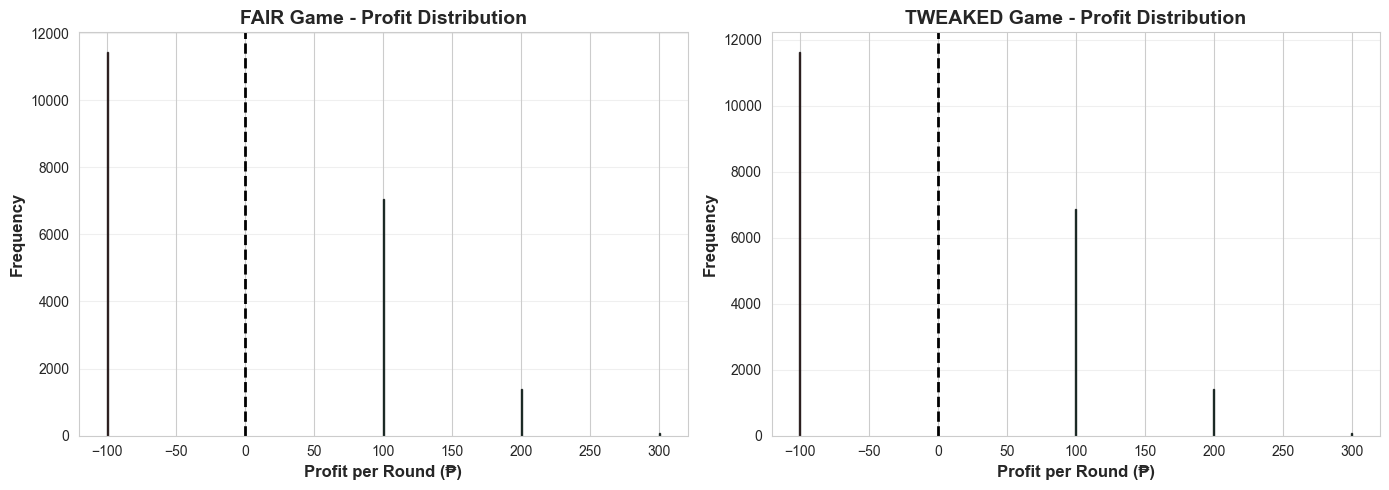

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, model in enumerate(df['model_type'].unique()):
    model_data = df[df['model_type'] == model]
    profit_counts = model_data['profit'].value_counts().sort_index()
    
    colors = ['#ef4444' if x < 0 else '#10b981' for x in profit_counts.index]
    bars = axes[idx].bar(profit_counts.index, profit_counts.values, 
                         color=colors, alpha=0.8, edgecolor='black')
    
    axes[idx].axvline(x=0, color='black', linestyle='--', linewidth=2)
    axes[idx].set_xlabel('Profit per Round (₱)', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Frequency', fontsize=12, fontweight='bold')
    axes[idx].set_title(f'{model.upper()} Game - Profit Distribution', 
                       fontsize=14, fontweight='bold')
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('profit_distribution_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

---
### **WIN/LOSS ANALYSIS**
---

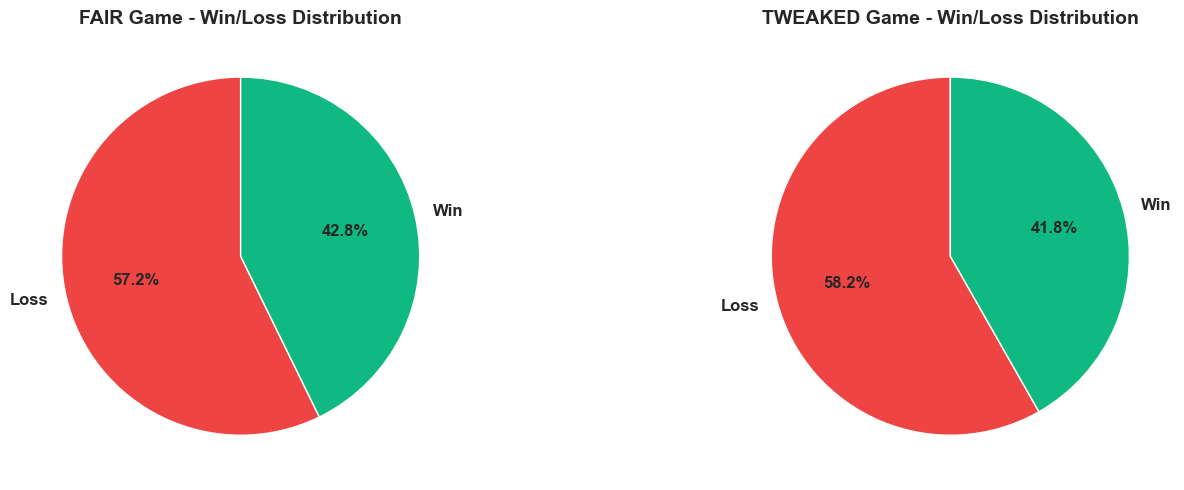

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for idx, model in enumerate(df['model_type'].unique()):
    model_data = df[df['model_type'] == model]
    
    win_loss_data = pd.DataFrame({
        'Outcome': ['Loss', 'Win'],
        'Count': [
            len(model_data[model_data['profit'] <= 0]),
            len(model_data[model_data['profit'] > 0])
        ]
    })
    
    colors = ['#ef4444', '#10b981']
    wedges, texts, autotexts = axes[idx].pie(
        win_loss_data['Count'], 
        labels=win_loss_data['Outcome'],
        autopct='%1.1f%%',
        colors=colors,
        startangle=90,
        textprops={'fontsize': 12, 'fontweight': 'bold'}
    )
    
    axes[idx].set_title(f'{model.upper()} Game - Win/Loss Distribution', 
                       fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('win_loss_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

---
### **COLOR SELECTION ANALYSIS**
---

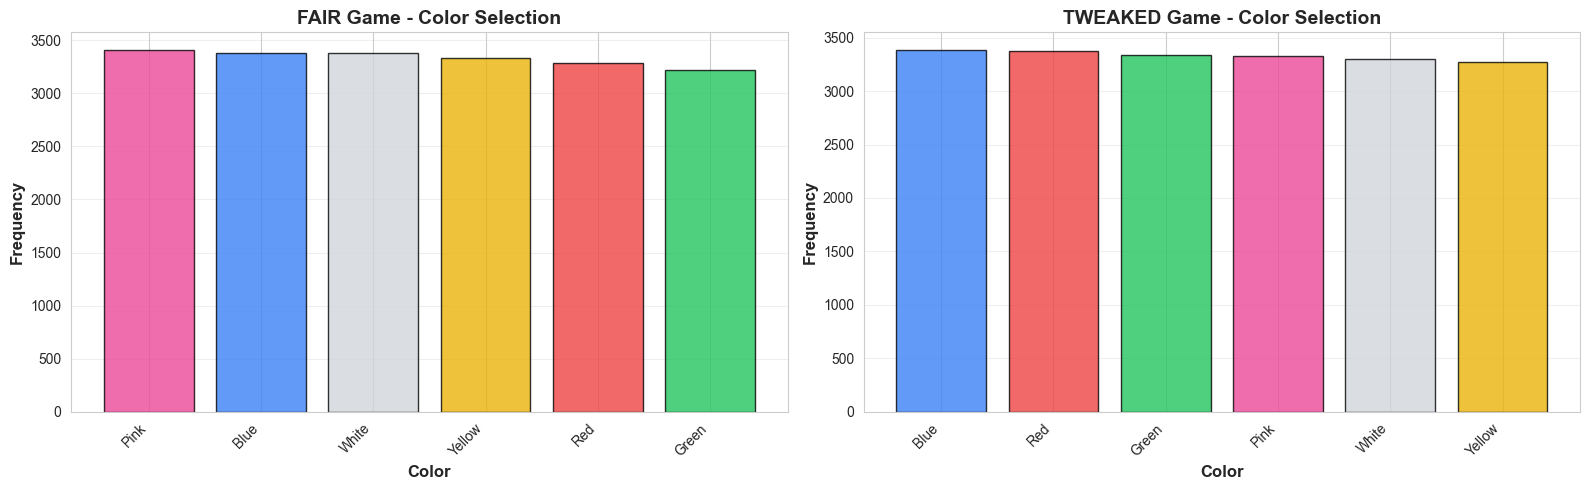

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

for idx, model in enumerate(df['model_type'].unique()):
    model_data = df[df['model_type'] == model]
    color_counts = model_data['selected_color'].value_counts()
    
    color_map = {
        'Red': '#ef4444',
        'Blue': '#3b82f6',
        'Green': '#22c55e',
        'Yellow': '#eab308',
        'White': '#d1d5db',
        'Pink': '#ec4899'
    }
    
    colors_list = [color_map.get(c, '#888888') for c in color_counts.index]
    
    bars = axes[idx].bar(range(len(color_counts)), color_counts.values, 
                         color=colors_list, alpha=0.8, edgecolor='black')
    axes[idx].set_xticks(range(len(color_counts)))
    axes[idx].set_xticklabels(color_counts.index, rotation=45, ha='right')
    axes[idx].set_xlabel('Color', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('Frequency', fontsize=12, fontweight='bold')
    axes[idx].set_title(f'{model.upper()} Game - Color Selection', 
                       fontsize=14, fontweight='bold')
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('color_selection_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

---
### **COLOR PERFORMANCE ANALYSIS**
---

In [60]:
print("\n" + "="*80)
print("COLOR PERFORMANCE ANALYSIS")
print("="*80)

for model in df['model_type'].unique():
    print(f"\n{model.upper()} Game:")
    model_data = df[df['model_type'] == model]
    
    color_stats = model_data.groupby('selected_color').agg({
        'profit': ['sum', 'mean', 'count'],
        'matches': 'mean'
    }).round(2)
    
    color_stats.columns = ['Total_Profit', 'Avg_Profit', 'Plays', 'Avg_Matches']
    color_stats['Win_Rate_%'] = (
        model_data[model_data['profit'] > 0].groupby('selected_color').size() / 
        model_data.groupby('selected_color').size() * 100
    ).round(2)
    
    print(color_stats.sort_values('Total_Profit', ascending=False))


COLOR PERFORMANCE ANALYSIS

FAIR Game:
                Total_Profit  Avg_Profit  Plays  Avg_Matches  Win_Rate_%
selected_color                                                          
Yellow                -11000       -3.30   3329         0.52       44.37
Blue                  -18100       -5.36   3380         0.51       43.17
Pink                  -18400       -5.40   3405         0.52       42.97
Green                 -22800       -7.07   3224         0.50       42.83
Red                   -25100       -7.65   3283         0.50       42.28
White                 -36200      -10.71   3379         0.48       40.93

TWEAKED Game:
                Total_Profit  Avg_Profit  Plays  Avg_Matches  Win_Rate_%
selected_color                                                          
Pink                   24500        7.35   3333         0.59       48.33
White                  19500        5.92   3296         0.58       48.00
Yellow                 18400        5.62   3276         0.58       47

---
### **SIDE-BY-SIDE COMPARISON METRICS**
---

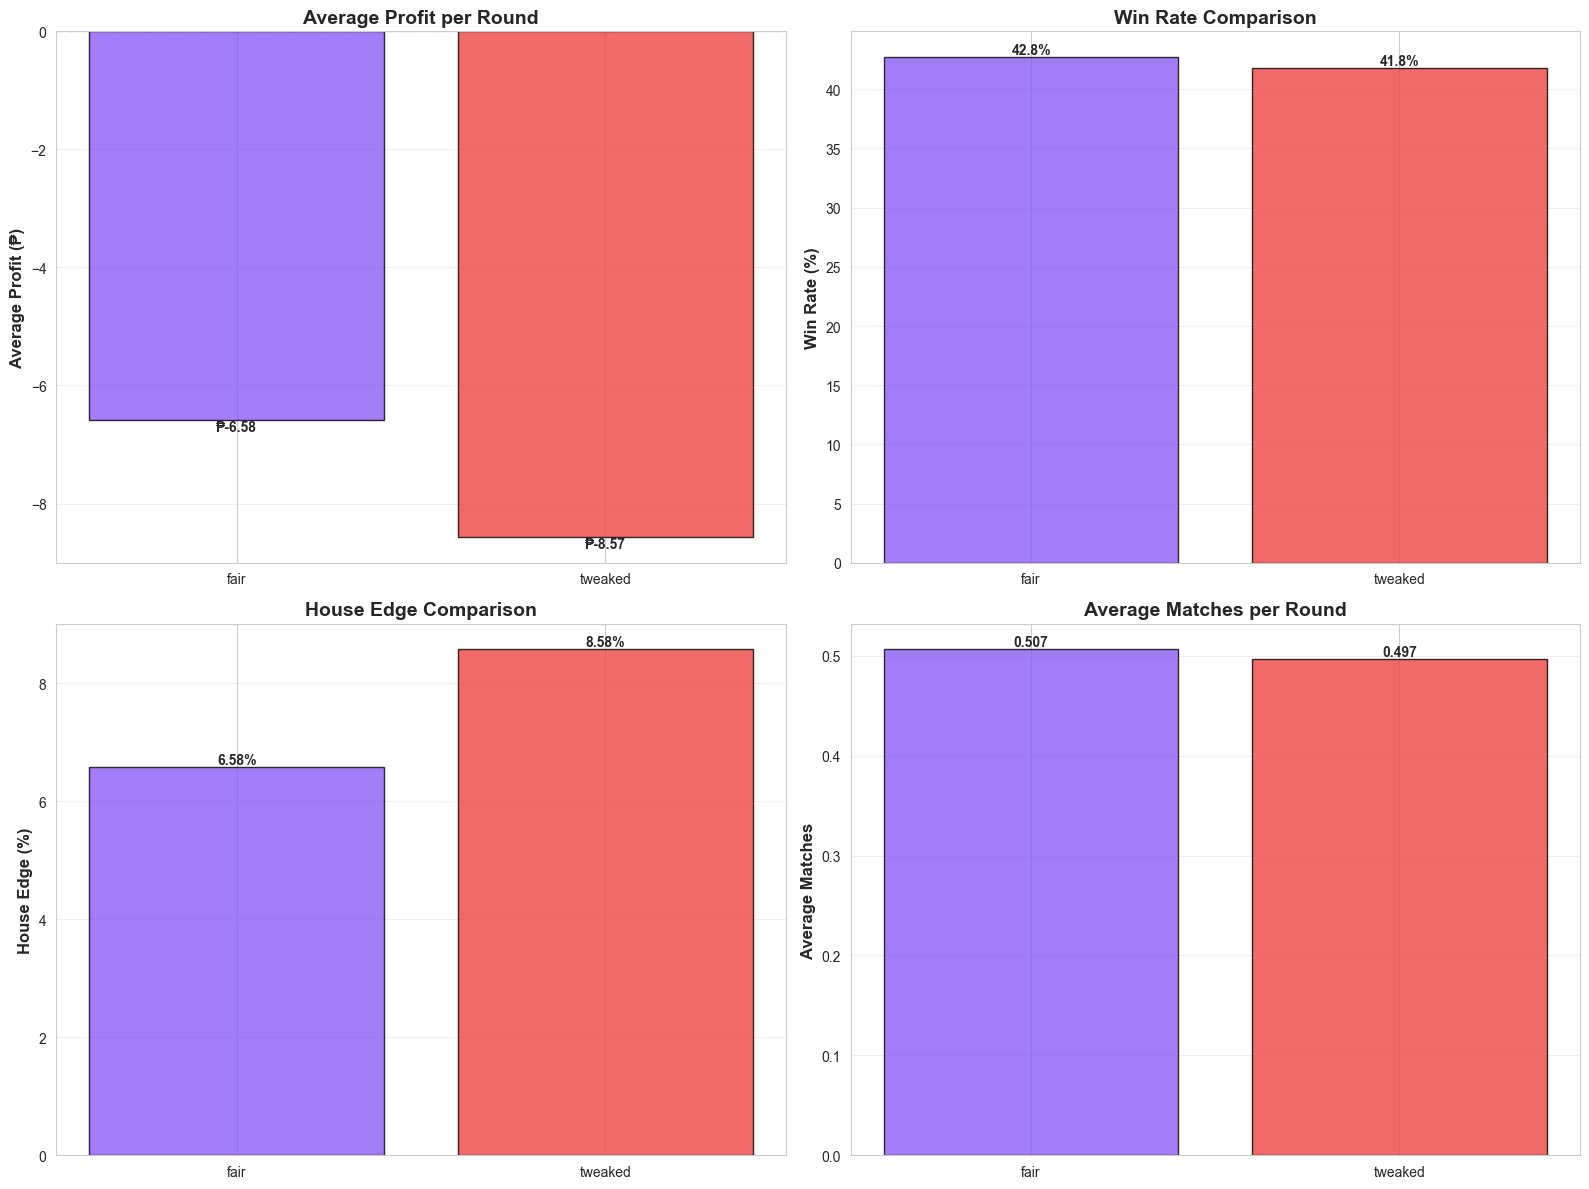

In [61]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 9.1 Average Profit per Round
models = df['model_type'].unique()
avg_profits = [df[df['model_type'] == m]['profit'].mean() for m in models]
colors_comp = ['#8b5cf6', '#ef4444']

axes[0, 0].bar(models, avg_profits, color=colors_comp, alpha=0.8, edgecolor='black')
axes[0, 0].axhline(y=0, color='black', linestyle='--')
axes[0, 0].set_ylabel('Average Profit (₱)', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Average Profit per Round', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(avg_profits):
    axes[0, 0].text(i, v, f'₱{v:.2f}', ha='center', 
                    va='bottom' if v > 0 else 'top', fontweight='bold')

# 9.2 Win Rate Comparison
win_rates = [(df[df['model_type'] == m]['profit'] > 0).mean() * 100 for m in models]

axes[0, 1].bar(models, win_rates, color=colors_comp, alpha=0.8, edgecolor='black')
axes[0, 1].set_ylabel('Win Rate (%)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Win Rate Comparison', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(win_rates):
    axes[0, 1].text(i, v, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

# 9.3 House Edge Comparison
house_edges = []
for m in models:
    model_data = df[df['model_type'] == m]
    total_bet = model_data['bet'].sum()
    house_profit = -model_data['profit'].sum()
    house_edge = (house_profit / total_bet) * 100
    house_edges.append(house_edge)

axes[1, 0].bar(models, house_edges, color=colors_comp, alpha=0.8, edgecolor='black')
axes[1, 0].set_ylabel('House Edge (%)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('House Edge Comparison', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(house_edges):
    axes[1, 0].text(i, v, f'{v:.2f}%', ha='center', va='bottom', fontweight='bold')

# 9.4 Average Matches per Round
avg_matches = [df[df['model_type'] == m]['matches'].mean() for m in models]

axes[1, 1].bar(models, avg_matches, color=colors_comp, alpha=0.8, edgecolor='black')
axes[1, 1].set_ylabel('Average Matches', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Average Matches per Round', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(avg_matches):
    axes[1, 1].text(i, v, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('comparison_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

---
### **SUMMARY REPORT**
---

In [62]:
print("\n" + "="*80)
print("FINAL SUMMARY REPORT")
print("="*80)

for model in df['model_type'].unique():
    model_data = df[df['model_type'] == model]
    
    total_rounds = len(model_data)
    total_bet = model_data['bet'].sum()
    total_profit = model_data['profit'].sum()
    house_profit = -total_profit
    house_edge = (house_profit / total_bet) * 100
    
    wins = len(model_data[model_data['profit'] > 0])
    losses = len(model_data[model_data['profit'] <= 0])
    win_rate = (wins / total_rounds) * 100
    
    max_profit = model_data['profit'].max()
    min_profit = model_data['profit'].min()
    avg_profit = model_data['profit'].mean()
    
    print(f"\n{model.upper()} GAME SUMMARY:")
    print(f"{'─' * 50}")
    print(f"Total Rounds:        {total_rounds:>10}")
    print(f"Total Wagered:       ₱{total_bet:>10,.2f}")
    print(f"Player Profit:       ₱{total_profit:>10,.2f}")
    print(f"House Profit:        ₱{house_profit:>10,.2f}")
    print(f"House Edge:          {house_edge:>10.2f}%")
    print(f"Win Rate:            {win_rate:>10.2f}%")
    print(f"Wins/Losses:         {wins:>5} / {losses:<5}")
    print(f"Max Single Profit:   ₱{max_profit:>10,.2f}")
    print(f"Max Single Loss:     ₱{min_profit:>10,.2f}")
    print(f"Avg Profit/Round:    ₱{avg_profit:>10,.2f}")


FINAL SUMMARY REPORT

FAIR GAME SUMMARY:
──────────────────────────────────────────────────
Total Rounds:             20000
Total Wagered:       ₱2,000,000.00
Player Profit:       ₱-131,600.00
House Profit:        ₱131,600.00
House Edge:                6.58%
Win Rate:                 42.75%
Wins/Losses:          8551 / 11449
Max Single Profit:   ₱    300.00
Max Single Loss:     ₱   -100.00
Avg Profit/Round:    ₱     -6.58

TWEAKED GAME SUMMARY:
──────────────────────────────────────────────────
Total Rounds:             20000
Total Wagered:       ₱2,000,000.00
Player Profit:       ₱-171,500.00
House Profit:        ₱171,500.00
House Edge:                8.58%
Win Rate:                 41.76%
Wins/Losses:          8352 / 11648
Max Single Profit:   ₱    300.00
Max Single Loss:     ₱   -100.00
Avg Profit/Round:    ₱     -8.57
